In [ ]:
%cd /content/drive/MyDrive/AI활용 소프트웨어 개발/12. 딥러닝/data

/content/drive/MyDrive/AI활용 소프트웨어 개발/12. 딥러닝/data


In [ ]:
!unzip -qq santa.zip

replace test/normal/552.not-a-santa.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import os
import shutil
import random
import torch
import glob
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder
from torchvision.models import vgg19, VGG19_Weights
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.data import SubsetRandomSampler

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
# 각 폴더에서 4개씩 샘플링
normal_files = random.sample(os.listdir('train/normal'), 4)
santa_files = random.sample(os.listdir('train/santa'), 4)

print(normal_files)
print(santa_files)

['147.not-a-santa.jpg', '208.not-a-santa.jpg', '452.not-a-santa.jpg', '92.not-a-santa.jpg']
['543.Santa.jpg', '378.Santa.jpg', '535.Santa.jpg', '72.Santa.jpg']


In [ ]:
# 파일 경로 리스트 생성
normal_paths = [os.path.join('train/normal', file) for file in normal_files]
santa_paths = [os.path.join('train/santa', file) for file in santa_files]

print(normal_paths)
print(santa_paths)

['train/normal/147.not-a-santa.jpg', 'train/normal/208.not-a-santa.jpg', 'train/normal/452.not-a-santa.jpg', 'train/normal/92.not-a-santa.jpg']
['train/santa/543.Santa.jpg', 'train/santa/378.Santa.jpg', 'train/santa/535.Santa.jpg', 'train/santa/72.Santa.jpg']


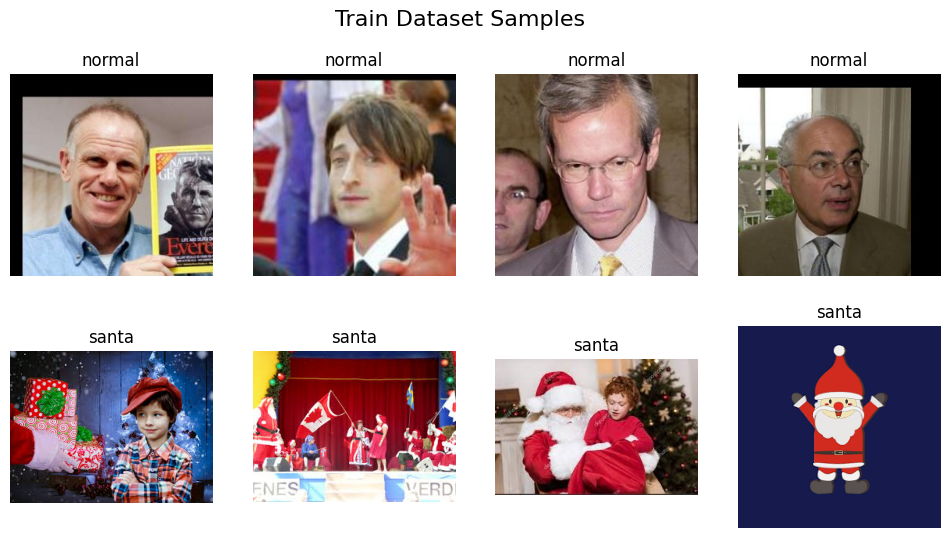

In [ ]:
# 이미지 시각화
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle("Train Dataset Samples", fontsize=16)

for i, file_path in enumerate(normal_paths):
    image = Image.open(file_path)
    axes[0, i].imshow(image)
    axes[0, i].axis("off")
    axes[0, i].set_title("normal")

for i, file_path in enumerate(santa_paths):
    image = Image.open(file_path)
    axes[1, i].imshow(image)
    axes[1, i].axis("off")
    axes[1, i].set_title("santa")
plt.show()

In [ ]:
# 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # RGB 모두 평균, 표편을 0.5로 맞춤
])

In [ ]:
train_dataset = ImageFolder('/content/drive/MyDrive/AI활용 소프트웨어 개발/12. 딥러닝/data/train', transform = transform)
val_dataset = ImageFolder('/content/drive/MyDrive/AI활용 소프트웨어 개발/12. 딥러닝/data/val', transform = transform)

In [ ]:
# 전체 데이터셋 크기 확인
len(train_dataset), len(val_dataset)

(895, 267)

In [ ]:
# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)  # 코어가 몇 개 사용할 지 설정
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
import torch
import torch.nn as nn

class VGG19(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG19, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),  # 입력 이미지 크기에 따라 다를 수 있음
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

# 모델 생성 예시
model = VGG19(num_classes=2)  # 예: 산타/일반인 2분류
print(model)


VGG19(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pa

In [ ]:
# 손실함수
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_model(optimizer_name, model, train_loader, val_loader, criterion, num_epoch=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # momentum=0.9: 지난 가중치를 90% 반영해라.
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))  # 평균과 분산을 동시에 넣어준다.
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
    else:
        raise ValueError(f"지원하지 않는 최적화 알고리즘: {optimizer_name}")


    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epoch):
        model.train()
        running_loss = 0.0

        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0.0
        model.eval()
        correct= 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

            val_loss /= len(val_loader)
            val_losses.append(val_loss)
            val_accuracy = correct / total * 100
            val_accuracies.append(val_accuracy)
            print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%', flush=True)


    return train_losses, val_losses, val_accuracies

In [ ]:
# SGD

train_losses_SGD, val_losses_SGD, val_accuracies_SGD = train_model('SGD', model, train_loader, val_loader, criterion)

[SGD] Epoch 1, Train Loss: 0.029212, Val Loss: 0.109113, Validation Accuracy: 94.38%
[SGD] Epoch 2, Train Loss: 0.022913, Val Loss: 0.110878, Validation Accuracy: 94.38%
[SGD] Epoch 3, Train Loss: 0.024179, Val Loss: 0.113776, Validation Accuracy: 94.38%
[SGD] Epoch 4, Train Loss: 0.022131, Val Loss: 0.110585, Validation Accuracy: 94.38%
[SGD] Epoch 5, Train Loss: 0.018112, Val Loss: 0.109445, Validation Accuracy: 94.38%
[SGD] Epoch 6, Train Loss: 0.022192, Val Loss: 0.113990, Validation Accuracy: 94.38%
[SGD] Epoch 7, Train Loss: 0.025987, Val Loss: 0.111563, Validation Accuracy: 94.38%
[SGD] Epoch 8, Train Loss: 0.020674, Val Loss: 0.114198, Validation Accuracy: 94.38%
[SGD] Epoch 9, Train Loss: 0.022307, Val Loss: 0.107269, Validation Accuracy: 94.76%
[SGD] Epoch 10, Train Loss: 0.025900, Val Loss: 0.106839, Validation Accuracy: 94.38%
[SGD] Epoch 11, Train Loss: 0.022631, Val Loss: 0.108991, Validation Accuracy: 94.38%
[SGD] Epoch 12, Train Loss: 0.032155, Val Loss: 0.105082, Valid

In [ ]:
# Adam

model = vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(4096, 2)
model.classifier[6].requires_grad = False

train_losses_Adam, val_losses_Adam, val_accuracies_Adam = train_model('Adam', model, train_loader, val_loader, criterion)

[Adam] Epoch 1, Train Loss: 0.249733, Val Loss: 0.154020, Validation Accuracy: 93.63%
[Adam] Epoch 2, Train Loss: 0.141569, Val Loss: 0.129914, Validation Accuracy: 95.51%
[Adam] Epoch 3, Train Loss: 0.100860, Val Loss: 0.125347, Validation Accuracy: 94.76%
[Adam] Epoch 4, Train Loss: 0.084477, Val Loss: 0.114939, Validation Accuracy: 94.76%
[Adam] Epoch 5, Train Loss: 0.071204, Val Loss: 0.113415, Validation Accuracy: 94.76%
[Adam] Epoch 6, Train Loss: 0.065996, Val Loss: 0.099951, Validation Accuracy: 95.13%
[Adam] Epoch 7, Train Loss: 0.056581, Val Loss: 0.106599, Validation Accuracy: 95.51%
[Adam] Epoch 8, Train Loss: 0.062408, Val Loss: 0.110225, Validation Accuracy: 94.76%
[Adam] Epoch 9, Train Loss: 0.054264, Val Loss: 0.112108, Validation Accuracy: 95.13%
[Adam] Epoch 10, Train Loss: 0.048584, Val Loss: 0.105576, Validation Accuracy: 94.76%
[Adam] Epoch 11, Train Loss: 0.037873, Val Loss: 0.111626, Validation Accuracy: 95.13%
[Adam] Epoch 12, Train Loss: 0.040123, Val Loss: 0.1

In [ ]:
# RAdam

model = vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(4096, 2)
model.classifier[6].requires_grad = True

train_losses_RAdam, val_losses_RAdam, val_accuracies_RAdam = train_model('RAdam', model, train_loader, val_loader, criterion)

[RAdam] Epoch 1, Train Loss: 0.539190, Val Loss: 0.395782, Validation Accuracy: 89.14%
[RAdam] Epoch 2, Train Loss: 0.330727, Val Loss: 0.274237, Validation Accuracy: 89.51%
[RAdam] Epoch 3, Train Loss: 0.241779, Val Loss: 0.224595, Validation Accuracy: 91.39%
[RAdam] Epoch 4, Train Loss: 0.203185, Val Loss: 0.192369, Validation Accuracy: 93.26%
[RAdam] Epoch 5, Train Loss: 0.172268, Val Loss: 0.169409, Validation Accuracy: 94.76%
[RAdam] Epoch 6, Train Loss: 0.154544, Val Loss: 0.160163, Validation Accuracy: 94.76%
[RAdam] Epoch 7, Train Loss: 0.129230, Val Loss: 0.144994, Validation Accuracy: 95.13%
[RAdam] Epoch 8, Train Loss: 0.126289, Val Loss: 0.136270, Validation Accuracy: 95.13%
[RAdam] Epoch 9, Train Loss: 0.106143, Val Loss: 0.128510, Validation Accuracy: 95.51%
[RAdam] Epoch 10, Train Loss: 0.110541, Val Loss: 0.124794, Validation Accuracy: 95.51%
[RAdam] Epoch 11, Train Loss: 0.092878, Val Loss: 0.122017, Validation Accuracy: 95.51%
[RAdam] Epoch 12, Train Loss: 0.085085, V

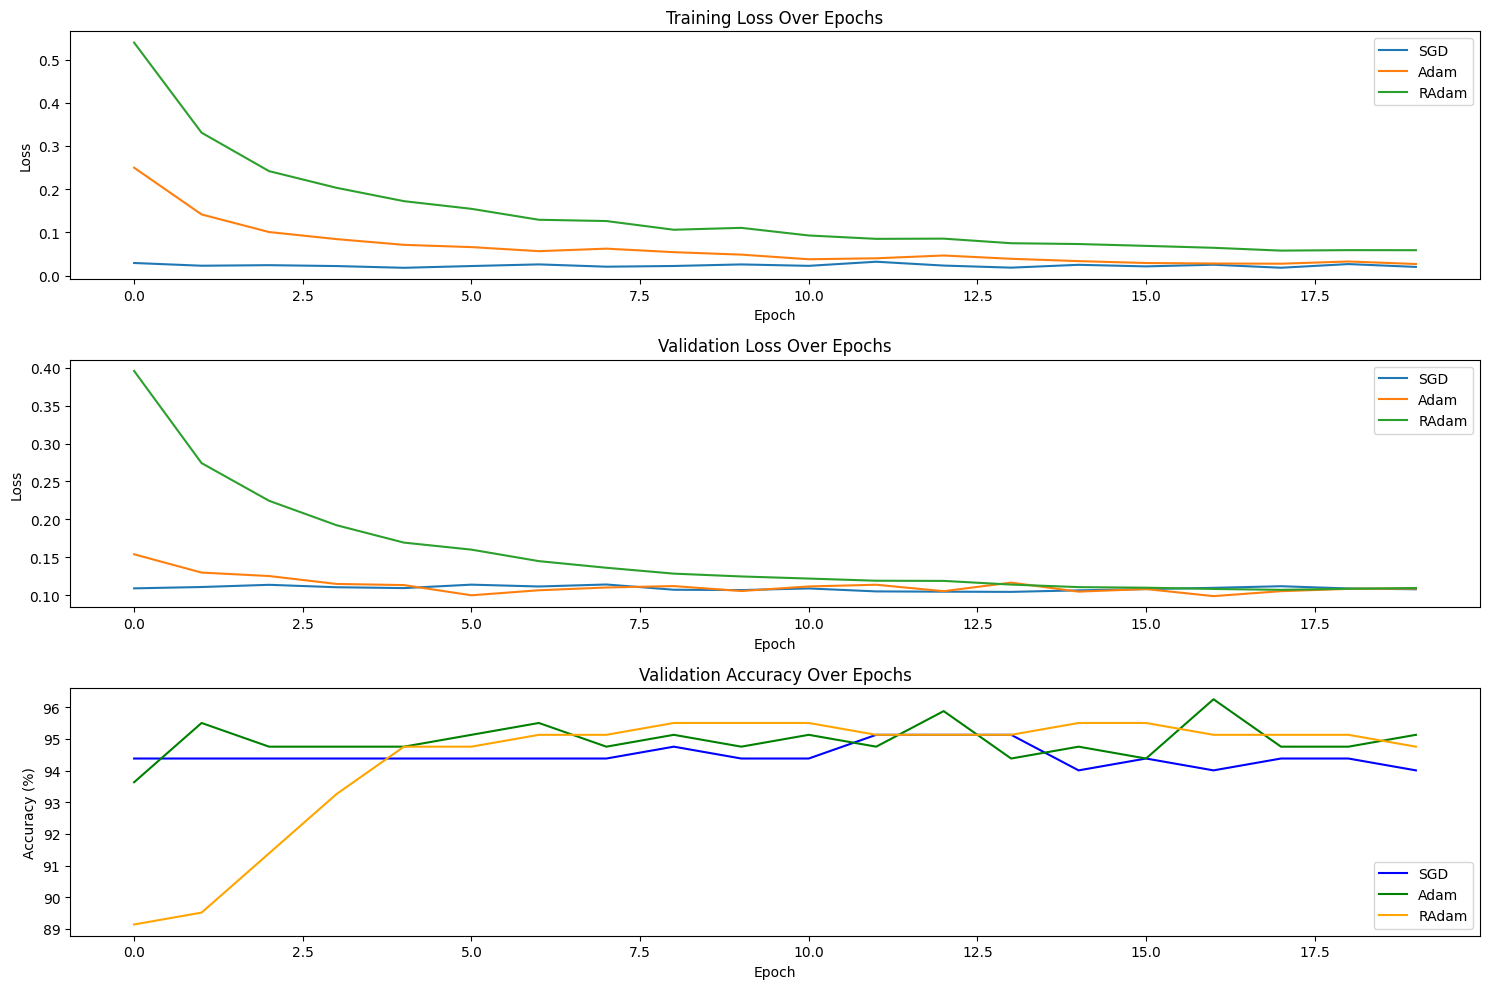

In [ ]:
# 학습 손실과 검증 정확도 그래프 그리기
plt.figure(figsize=(15, 10))

# 학습 손실 그래프
plt.subplot(3, 1, 1)  # 3행 1열의 첫 번째 위치
plt.plot(train_losses_SGD, label='SGD')
plt.plot(train_losses_Adam, label='Adam')
plt.plot(train_losses_RAdam, label='RAdam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 검증 손실 그래프
plt.subplot(3, 1, 2)  # 3행 1열의 두 번째 위치
plt.plot(val_losses_SGD, label='SGD')
plt.plot(val_losses_Adam, label='Adam')
plt.plot(val_losses_RAdam, label='RAdam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

# 검증 정확도 그래프
plt.subplot(3, 1, 3)  # 3행 1열의 세 번째 위치
plt.plot(val_accuracies_SGD, label='SGD', color='blue')
plt.plot(val_accuracies_Adam, label='Adam', color='green')
plt.plot(val_accuracies_RAdam, label='RAdam', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0).to(device)

In [ ]:
# 클래스별 폴더 경로
class_folders = {
    'normal': '/content/drive/MyDrive/AI활용 소프트웨어 개발/12. 딥러닝/data/santa/test/normal',
    'santa': '/content/drive/MyDrive/AI활용 소프트웨어 개발/12. 딥러닝/data/santa/test/santa'
}

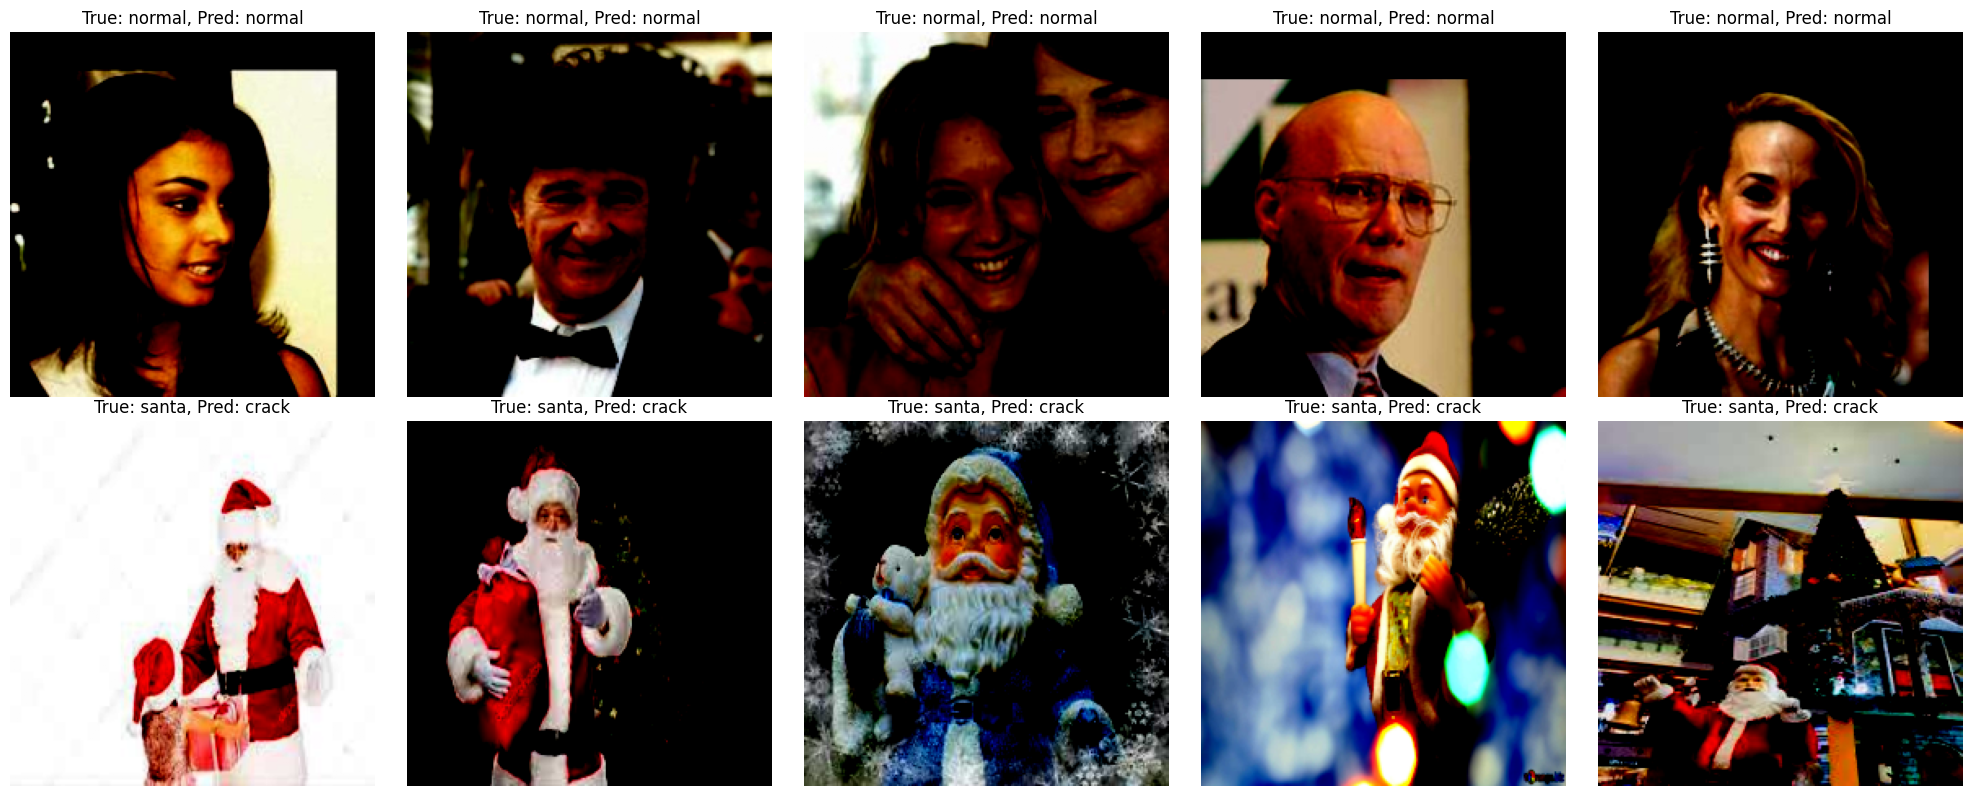

In [ ]:
plt.figure(figsize=(20, 8))
# subplot 인덱스를 위한 카운터
counter = 1

# 각 클래스별로 5장의 이미지 추론 및 시각화
for class_name, folder_path in class_folders.items():
    # 해당 클래스의 이미지 경로 가져오기
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:5]  # 첫 5장 선택

    for image_path in selected_paths:
        image = load_and_transform_image(image_path, transform)

        image = image.to(device)

        model.eval()  # 모델을 평가 모드로 설정
        # 모델을 사용한 추론
        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)

        prediction = 'normal' if predicted.item() == 0 else 'crack'

        # 결과 시각화
        plt.subplot(2, 5, counter)
        # plt.imshow(Image.open(image_path))
        img_np = image.squeeze(0).cpu().permute(1, 2, 0).numpy()  # [H, W, 3]
        plt.imshow(img_np)
        plt.title(f'True: {class_name}, Pred: {prediction}')
        plt.axis('off')

        counter += 1  # subplot 인덱스 업데이트

plt.tight_layout()
plt.show()


In [ ]:
torch.save(model.state_dict(), 'santa(3)_model_weights.pth')
torch.save(model, 'santa(3)_model.pt')